In [90]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from os import path
from fantasyfootball.config import DATA_DIR, pfr_to_fantpros, nfl_color_map
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [154]:
file_path = r'..\data\weekly-analysis\2020'
week1_raw = pd.read_csv(path.join(file_path,'2020_week_1.csv'))
week2_raw = pd.read_csv(path.join(file_path,'2020_week_2.csv'))

In [4]:
week1_raw.head()

,rk,player_name,pos,age,date,lg,tm,home/away,opp,result,g#,week,day,rushing_att,rushing_yds,rushing_y/a,rushing_td,receiving_tgt,receiving_rec,receiving_yds,receiving_y/r,receiving_td,receiving_y/tgt
0,1,Clyde Edwards-Helaire,RB,21.152,2020-09-10,NFL,KAN,Home,HOU,W 34-20,1,1,Thu,25.0,138.0,5.52,1.0,2.0,0.0,0.0,NaN,0.0,0.00
1,2,Derrick Henry,RB,26.254,2020-09-14,NFL,TEN,Away,DEN,W 16-14,1,1,Mon,31.0,116.0,3.74,0.0,3.0,3.0,15.0,5.00,0.0,5.00
2,3,Benny Snell Jr.,RB,22.200,2020-09-14,NFL,PIT,Away,NYG,W 26-16,1,1,Mon,19.0,113.0,5.95,0.0,1.0,0.0,0.0,NaN,0.0,0.00
3,4,Christian McCaffrey,RB,24.098,2020-09-13,NFL,CAR,Home,LVR,L 30-34,1,1,Sun,23.0,97.0,4.22,2.0,4.0,3.0,38.0,12.67,0.0,9.50
4,5,Ezekiel Elliott,RB,25.053,2020-09-13,NFL,DAL,Away,LAR,L 17-20,1,1,Sun,22.0,96.0,4.36,1.0,4.0,3.0,31.0,10.33,1.0,7.75


In [10]:
def pfr_transform_df(df):
    df = (df.copy()
            .rename(columns={'receiving_tgt': 'tgt_ind', 'rushing_att': 'att_ind'})
            .replace({'tm': pfr_to_fantpros})
         )
    df['att_tm'] = df.loc[df['pos'] == 'RB'].groupby('tm')['att_ind'].transform('sum')
    df['tgt_tm'] = df.groupby('tm')['tgt_ind'].transform('sum')
    df['rushing_share'] = df['att_ind'] / df['att_tm']
    df['tgt_share'] = df['tgt_ind'] / df['tgt_tm']
    return df

In [155]:
week1 = pfr_transform_df(week1_raw)
week2 = pfr_transform_df(week2_raw)

In [157]:
#concat week 1 and 2
week1_and_week2 = pd.concat([week1_raw, week2_raw])
#normalize odd pos
pos_map= {'WR/RS': 'WR', 'RB/WR': 'RB', 'HB': 'RB'}
week1_and_week2 = week1_and_week2.replace({'pos': pos_map})
#groupby to agg player stats
week1_and_week2 = week1_and_week2.groupby(['player_name','tm', 'pos'], as_index=False)[['receiving_tgt', 'rushing_att']].sum()
week1_and_week2 = pfr_transform_df(week1_and_week2)

In [13]:
# add your players to the list so we can highlight them in the charts
player_list = [
        'Clyde Edwards-Helaire',
        'Allen Robinson II',
        'Adam Thielen',
        'Robert Woods',
        'Austin Ekeler',
        'Joe Mixon',
        'Terry McLaurin',
        'Todd Gurley II',
        'Chris Carson',
        'Stefon Diggs',
        'Miles Sanders',
        'Diontae Johnson',
        'Jarvis Landry',
        'CeeDee Lamb',
        'Melvin Gordon III',
        'John Brown',
        'Hunter Henry',
        'Mark Ingram II',
        'James White',
        'Hayden Hurst',
        'Sammy Watkins',
        'Tarik Cohen',
        'Christian Kirk',
        'Chris Herndon IV',
        'Leonard Fournette',
        'Boston Scott',
        'Frank Gore',
        'Chris Thompson',
        'Michael Thomas',
        'George Kittle',
        'Jack Doyle',
        'Jordan Reed']

In [14]:
def make_rb_tgt_share_viz(df, pos='RB', x_size=20, y_size=15, player_list=None):
    df = df.loc[(df['pos'] == pos) & (df['tgt_share'] > 0) & (df['rushing_share'] > 0)]
    week = df['week'].max()
    season = df['date'][0][:4]
    if player_list is not None:
        player_color = dict.fromkeys(player_list, 'red')
    sns.set_style('whitegrid');
    plt.figure(figsize=(x_size, y_size))
    plt.yticks(np.linspace(0, df['tgt_share'].max(), 15));
    plt.xticks(np.linspace(0, df['rushing_share'].max(), 15));

    plt.xlabel('Rushing Share');
    plt.ylabel('Target Share');
    plt.title(f'{pos} rushing share vs. target share for {season} week {week}', fontsize=16);

    for _, row in df.iterrows():
        ax = plt.gca()
        player = row['player_name']
        if player in player_list:
            plt.scatter(row['rushing_share'], row['tgt_share'], color='red', alpha=1.0, zorder=2)
            ax.annotate(row['player_name'], xy=(row['rushing_share']+.01, row['tgt_share']), alpha=1.0, zorder=2)
        else:
            plt.scatter(row['rushing_share'], row['tgt_share'], color='blue', alpha=0.5, zorder=1)
            ax.annotate(row['player_name'], xy=(row['rushing_share']+.01, row['tgt_share']), alpha=0.5, zorder=1)

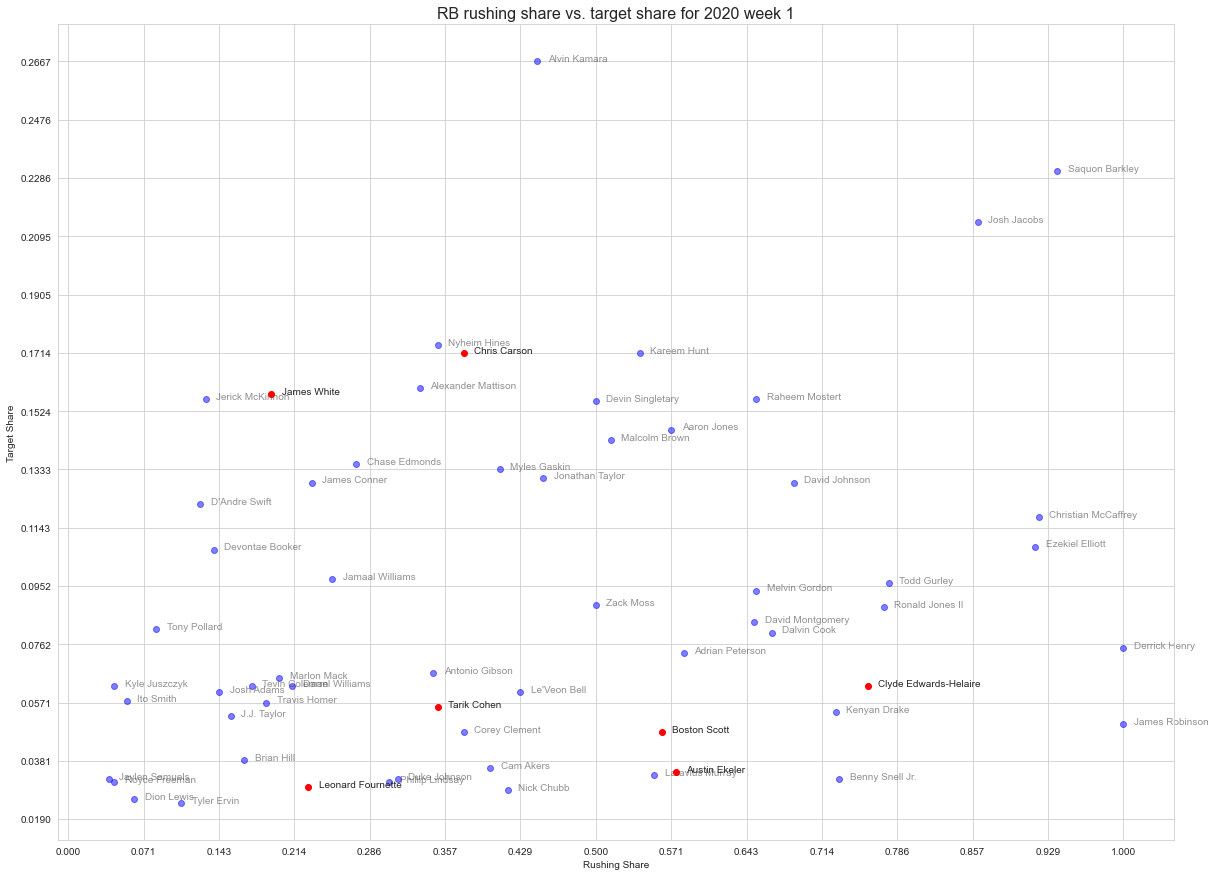

In [15]:
make_rb_tgt_share_viz(week1, player_list=player_list)

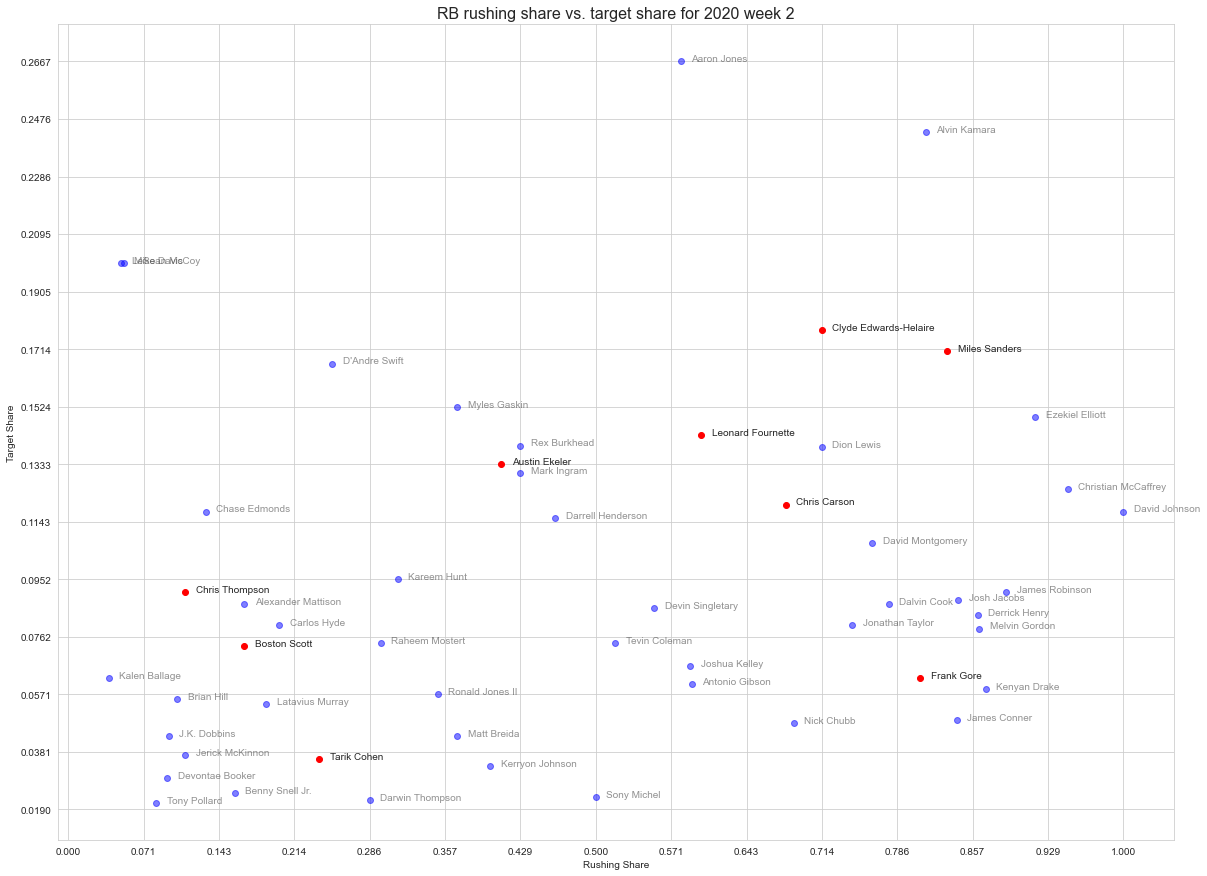

In [16]:
make_rb_tgt_share_viz(week2, player_list=player_list)

In [17]:
def make_rb_tgt_share_viz_cumulative(df, pos='RB', x_size=20, y_size=15, player_list=None):
    df = df.loc[(df['pos'] == pos) & (df['tgt_share'] > 0) & (df['rushing_share'] > 0)]
    if player_list is not None:
        player_color = dict.fromkeys(player_list, 'red')
    sns.set_style('whitegrid');
    plt.figure(figsize=(x_size, y_size))
    plt.yticks(np.linspace(0, df['tgt_share'].max(), 15));
    plt.xticks(np.linspace(0, df['rushing_share'].max(), 15));

    plt.xlabel('Rushing Share');
    plt.ylabel('Target Share');
    plt.title(f'{pos} rushing share vs. target share for YTD 2020', fontsize=16);

    for _, row in df.iterrows():
        ax = plt.gca()
        player = row['player_name']
        if player in player_list:
            plt.scatter(row['rushing_share'], row['tgt_share'], color='red', alpha=1.0, zorder=2)
            ax.annotate(row['player_name'], xy=(row['rushing_share']+.01, row['tgt_share']), alpha=1.0, zorder=2)
        else:
            plt.scatter(row['rushing_share'], row['tgt_share'], color='blue', alpha=0.5, zorder=1)
            ax.annotate(row['player_name'], xy=(row['rushing_share']+.01, row['tgt_share']), alpha=0.5, zorder=1)

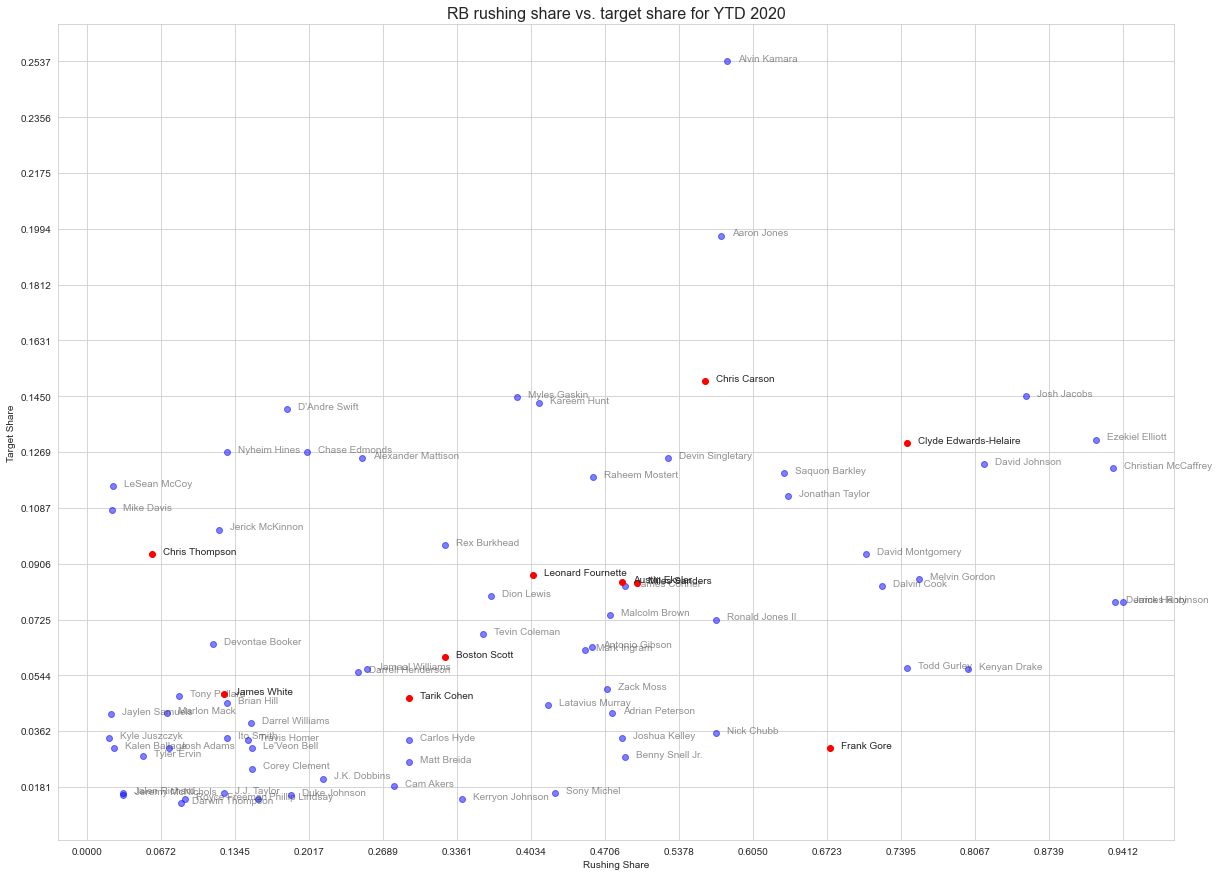

In [18]:
make_rb_tgt_share_viz_cumulative(week1_and_week2, player_list=player_list)

In [158]:
#team by team targetshare

week1_and_week2[['tm', 'player_name', 'tgt_share']].sort_values(['tm', 'tgt_share'], ascending=(True, False))

,tm,player_name,tgt_share
351,ARI,DeAndre Hopkins,0.352113
821,ARI,Larry Fitzgerald,0.169014
215,ARI,Chase Edmonds,0.126761
241,ARI,Christian Kirk,0.126761
303,ARI,Dan Arnold,0.056338
768,ARI,Kenyan Drake,0.056338
60,ARI,Andy Isabella,0.042254
304,ARI,Dan Arnold,0.028169
908,ARI,Maxx Williams,0.028169
331,ARI,Darrell Daniels,0.014085


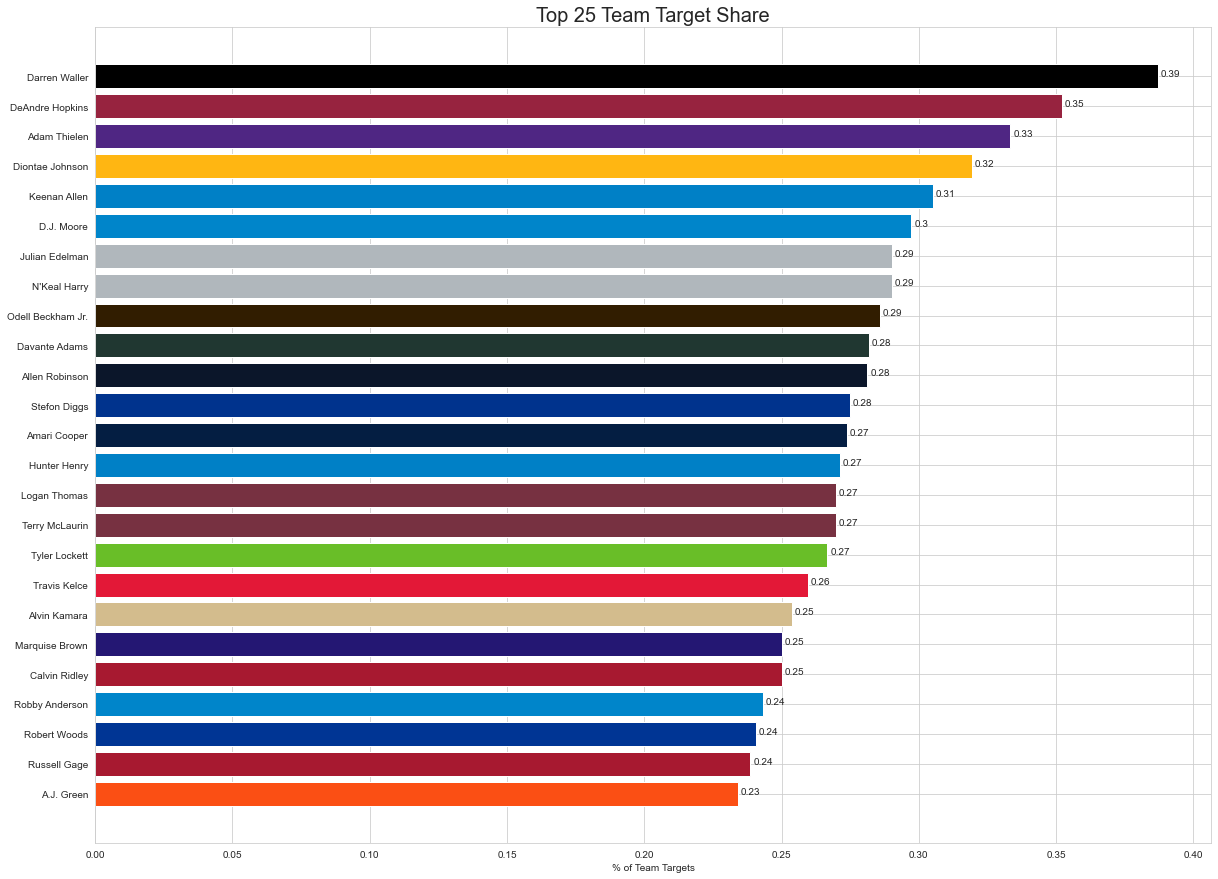

In [160]:
# horizontal bar of the top 25 target share through week 2
pos_list = ['RB', 'TE', 'WR']
hbar_df = week1_and_week2.sort_values('tgt_share',ascending=False).head(25).reset_index().copy()
hbar_df = hbar_df.loc[hbar_df['pos'].isin(pos_list)]
fig,ax = plt.subplots(figsize=(20, 15))

plt.gca().invert_yaxis()
for _, row in hbar_df.iterrows():
    player = row['player_name']
    team = row['tm']
    ax.barh(player, row['tgt_share'],  color=nfl_color_map[team])
    ax.annotate(round(row['tgt_share'],2), xy=(row['tgt_share']+0.001, player))
plt.xlabel('% of Team Targets')
plt.title('Top 25 Team Target Share', fontsize=20);


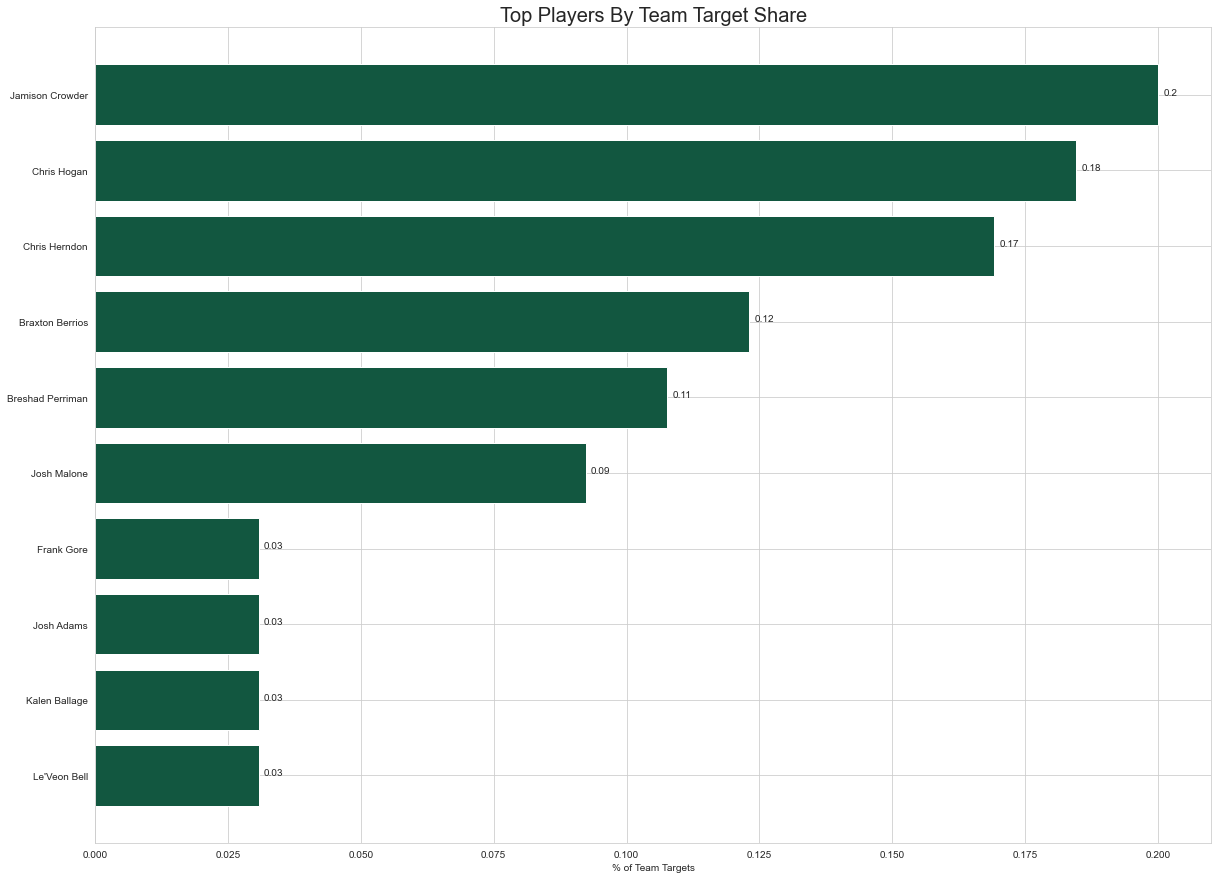

In [166]:
# horizontal bar of the top 25 target share through week 2
team = week1_and_week2['tm'] == 'NYJ'
reception = week1_and_week2['tgt_share'] > 0
pos_screen = week1_and_week2['pos'].isin(pos_list)

hbar_df = week1_and_week2.loc[team & reception & pos_screen].sort_values('tgt_share',ascending=False).head(25).reset_index().copy()

fig,ax = plt.subplots(figsize=(20, 15))

plt.gca().invert_yaxis()
for _, row in hbar_df.iterrows():
    player = row['player_name']
    team = row['tm']
    ax.barh(player, row['tgt_share'],  color=nfl_color_map[team])
    ax.annotate(round(row['tgt_share'],2), xy=(row['tgt_share']+0.001, player))
plt.xlabel('% of Team Targets')
plt.title('Top Players By Team Target Share', fontsize=20);
